In [1]:
import numpy as np
import math
import pandas as pd
import random

import thinkstats2
import thinkplot
import brfss
import nsfg
import first

In [2]:
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

In [3]:
inter, slope = thinkstats2.LeastSquares(ages, weights)
fit_xs, fit_ys = thinkstats2.FitLine(ages, inter, slope)
inter, slope

(6.8303969733110526, 0.017453851471802756)

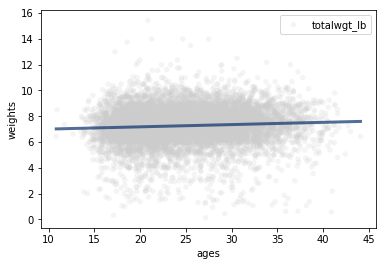

In [4]:
thinkplot.Scatter(ages, weights, color='0.8')
thinkplot.Plot(fit_xs, fit_ys)
thinkplot.Config(xlabel='ages', ylabel='weights')

In [5]:
live['residual'] = thinkstats2.Residuals(ages, weights, inter, slope)

In [6]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

In [7]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

In [8]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

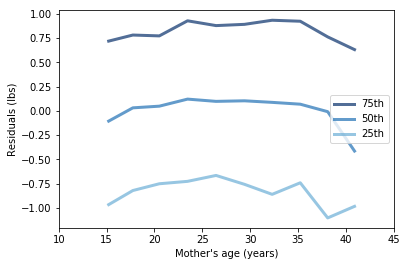

In [9]:
PlotPercentiles(age_means, cdfs)
thinkplot.Config(xlabel="Mother's age (years)", ylabel='Residuals (lbs)', xlim=[10, 45])

In [10]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = thinkstats2.LeastSquares(ages, weights)
        t.append(estimates)
        
    inters, slopes = zip(*t)
    return inters, slopes

In [11]:
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean. SE, ci', mean, stderr, ci)

In [12]:
inters, slopes = SamplingDistributions(live, iters=1001)

In [13]:
Summarize(inters)

mean. SE, ci 6.8314189480502625 0.07139037987241813 (6.715591148836479, 6.950245520644921)


In [14]:
Summarize(slopes)

mean. SE, ci 0.01742011662883075 0.0028008846508252917 (0.012900340254433982, 0.022065441074931795)


In [15]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        fys_seq.append(fys)
    
    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

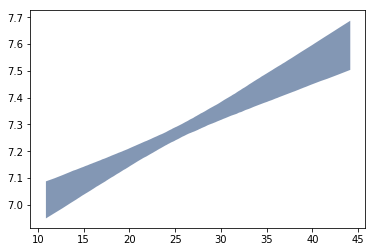

In [16]:
PlotConfidenceIntervals(live.agepreg.values, inters, slopes)

### Exercise

In [17]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean() for _ in range(1000)]
Summarize(estimates)

mean. SE, ci 7.265801504757689 0.015000982508211514 (7.239938315999114, 7.289728092498341)


## Coefficient of Determination

In [47]:
from thinkstats2 import Std, Var, MeanVar, Mean

def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [48]:
inter, slope = thinkstats2.LeastSquares(ages, weights)
res = thinkstats2.Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.00473811547471048

In [49]:
print('rho', thinkstats2.Corr(ages, weights))
print('r', np.sqrt(r2))

rho 0.06883397035410908
r 0.0688339703541099


In [50]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.40821553384062
Std(res) 1.4048754287857832


In [52]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

In [56]:
class SlopeTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope
    
    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar
        
    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [59]:
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ht = SlopeTest((live.agepreg, live.totalwgt_lb))
pvalue = ht.PValue()
pvalue, ht.actual, ht.MaxTestStat()

(0.0, 0.017453851471802756, 0.00862691318860624)

In [58]:
inters, slopes = SamplingDistributions(live, iters=1001)
slope_cdf = thinkstats2.Cdf(slopes)
pvalue = slope_cdf[0]
pvalue

0

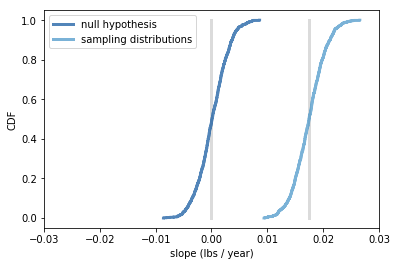

In [60]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(slope_cdf, label='sampling distributions')
thinkplot.Config(xlabel='slope (lbs / year)', ylabel='CDF', xlim=[-0.03, 0.03], legend=True, loc='upper left')

In [61]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample    

In [72]:
iters = 100
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean() for _ in range(iters)]
estimatesW = [ResampleRowsWeighted(live).totalwgt_lb.mean() for _ in range(iters)]

In [73]:
Summarize(estimates)

mean. SE, ci 7.26586551228148 0.014242170266180128 (7.243617227262669, 7.290350464704581)


In [74]:
Summarize(estimatesW)

mean. SE, ci 7.3457725713653454 0.013480936630294277 (7.324414970126134, 7.3687002102235)


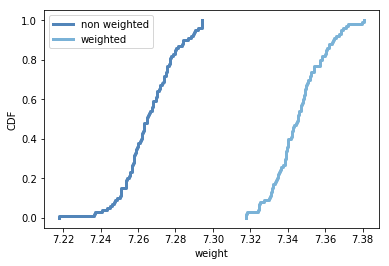

In [75]:
estimates_cdf = thinkstats2.Cdf(estimates)
estimatesW_cdf = thinkstats2.Cdf(estimatesW)

thinkplot.PrePlot(2)
thinkplot.Cdf(estimates_cdf, label='non weighted')
thinkplot.Cdf(estimatesW_cdf, label='weighted')
thinkplot.Config(xlabel='weight', ylabel='CDF', legend=True)

# Exercises 